<a href="https://colab.research.google.com/github/weswest/MSDS453/blob/main/MSDS453_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Imports and Setup

## 0.1 Instructor-Provided Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from dataclasses import dataclass
from timeit import default_timer as timer

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

import gensim
from gensim.models import Word2Vec

import spacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
tf.random.set_seed(2022)
import tensorflow.keras.backend as k

from typing import List, Callable, Dict, Tuple, Set

In [2]:
# Check if package is installed
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    # If package is not installed, download and install it
    !python -m spacy download en_core_web_lg -q
    nlp = spacy.load("en_core_web_lg")

In [3]:
try:
    nltk.data.find('stopwords')
    nltk.data.find('wordnet')
    nltk.data.find('punkt')
    nltk.data.find('corpora/omw')
except LookupError:
    nltk.download('stopwords',quiet=True)
    nltk.download('wordnet',quiet=True)
    nltk.download('punkt',quiet=True)
    nltk.download('omw-1.4',quiet=True)

In [4]:
import pkg_resources
#pkg_resources.require("gensim<=3.8.3");

print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.1


In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 0.2 Wes-Provided Imports

In [6]:
import random
import os

random_seed = 453
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

from matplotlib.ticker import MaxNLocator

from collections import Counter

import csv
import pickle
folder = 'train'

In [7]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.dpi'] = 50

In [8]:
! (rm -rf /tmp/barryc; mkdir /tmp/barryc; cd /tmp/barryc; git clone https://github.com/rock3125/enhanced-subject-verb-object-extraction.git )
! ls -l /tmp/barryc

#https://stackoverflow.com/questions/9714635/how-to-install-a-python-module-without-a-setup-py
import sys
sys.path.append("/tmp/barryc/enhanced-subject-verb-object-extraction")

# test of subject_verb_object_extract module
from subject_verb_object_extract import findSVOs, nlp as nlp2
tokens = nlp2("Seated in Mission Control, Chris Kraft neared the end of a tedious Friday afternoon as he monitored a seemingly interminable ground test of the Apollo 1 spacecraft.")
svos = findSVOs(tokens)
print(svos)

Cloning into 'enhanced-subject-verb-object-extraction'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 61 (delta 2), reused 1 (delta 1), pack-reused 55
Unpacking objects: 100% (61/61), 21.90 KiB | 1.22 MiB/s, done.
total 4
drwxr-xr-x 3 root root 4096 May 14 03:42 enhanced-subject-verb-object-extraction
[('Chris Kraft', 'neared', 'the end of a tedious Friday afternoon'), ('he', 'monitored', 'a interminable ground test of the Apollo spacecraft')]


## 0.3 Mount GDrive

In [9]:
from google.colab import drive
drive.mount('/content/drive')
try:
  os.chdir("drive/My Drive/MSDS/453/A3")
except:
  pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.4 TA-Provided Functions

### 0.4.1 Data Wrangling Functions

In [10]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)
    
def get_corpus_df(path: str) -> pd.DataFrame:
    data = pd.read_csv(path,encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

def remove_punctuation(text: str) -> str:
    return re.sub('[^a-zA-Z]', '', str(text))

def remove_tags(text: str) -> str:    
    return re.sub('&lt;/?.*?&gt;', '', text)

def remove_special_chars_and_digits(text: str) -> str:
    return re.sub('(\\d|\\W)+', '', text)

def get_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_coref_resolved_sentences(text: str) -> List[str]:
    return [str(x) for x in nlp(text).sents]

def get_lemmas(text: str, stopwords: Set[str]) -> List[str]:
    initial = [remove_tags(remove_special_chars_and_digits(remove_punctuation(x.lemma_.lower()))) for x in nlp(text)]
    return [x for x in initial if x not in stopwords]

def lemmatize_sentence(text: str, stopwords: Set[str]) -> str:
    return ' '.join(get_lemmas(text, stopwords))

def clean_doc(doc): 
    #doc = remove_punctuation(doc)
    doc= ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)
    return doc

def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

def counter_word(text):
  count=Counter()
  for i in text.values:
    for word in i.split():
      count[word]=+1
  return count

### 0.4.2 Knowledge Context Graph Functions

In [11]:
def map_edges(map_to: str, map_from: Set[str], df: pd.DataFrame):
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    df['edge'] = np.where(kg_df.edge.isin(map_from), map_to, kg_df.edge)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {sum(df.edge == map_to)}')
    
def map_sources_and_targets(map_to: str, map_from: Set[str], df: pd.DataFrame):
    before = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'Before mapping {", ".join(map_from)} -> {map_to}: {before}')
    
    df['source'] = np.where(kg_df.source.isin(map_from), map_to, kg_df.source)
    df['target'] = np.where(kg_df.target.isin(map_from), map_to, kg_df.target)
    
    after = sum(df.source == map_to) + sum(df.target == map_to)
    print(f'After mapping {", ".join(map_from)} -> {map_to}: {after}')
    
def get_neighborhood(sources: Set[str], edge_types: Set[str], depth: int, df: pd.DataFrame) -> pd.DataFrame:
    output = []
    
    for d in range(depth):
        if edge_types is not None:
            rows = df[(df.edge.isin(edge_types)) & ((df.source.isin(sources)) | (df.target.isin(sources)))].copy()
        else:
            rows = df[(df.source.isin(sources)) | (df.target.isin(sources))].copy()
            
        output.append(rows)
        sources = set(rows.target).union(set(rows.source))
        
    return pd.concat(output).drop_duplicates()

def find_sources_and_targets_with_patterns(patterns: List[str], df: pd.DataFrame):
    mask = np.zeros(df.shape[0])
    for pattern in patterns:
        mask = mask | (df.source.str.contains(pattern)) | (df.target.str.contains(pattern)) | (df.edge.str.contains(pattern))
        
    return df[mask]
# Examples of how to use the function:
# find_sources_and_targets_with_patterns(['action'], kg_df)
# find_sources_and_targets_with_patterns(['terror'], kg_df)
# find_sources_and_targets_with_patterns(['novel'], kg_df)
# find_sources_and_targets_with_patterns(['director', 'campbell'], kg_df)


def plot_graph(df: pd.DataFrame, show_edges: bool = False, figsize: Tuple[int, int] = (12, 12), use_circular: bool=True):
    graph = nx.from_pandas_edgelist(df, "source", "target", edge_attr='edge', create_using=nx.MultiDiGraph())

    plt.figure(figsize=figsize)
    if use_circular:
        pos = nx.circular_layout(graph)
    else:
        pos = nx.kamada_kawai_layout(graph)
        
    nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
    if show_edges:
        nx.draw_networkx_edge_labels(graph, pos=pos, font_size=8)
        
    plt.show()
    
def get_top_sources_and_targets(df: pd.DataFrame, top: int = 10):
    return (Counter(df.source) + Counter(df.target)).most_common(top)

def get_top_edges(df: pd.DataFrame, top: int = 10):
    return Counter(df.edge).most_common(top)

def get_dataset_partitions_pd(df, train_split=0.8, val_split=0.10, test_split=0.10):
       # Specify seed to always have the same split distribution between runs
    df_sample = df.sample(frac=1, random_state=12)
    indices_or_sections = [int(.8*len(df)), int(.9*len(df))]
    train_ds, val_ds, test_ds = np.split(df_sample, indices_or_sections)
    return train_ds, val_ds, test_ds

### 0.4.3 Entity Extraction Functions

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)
        
        # Matcher class object 
        matcher = Matcher(nlp.vocab)

        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        
        return(span.text)
    except:
        pass
    
def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

### 0.4.4 Visualization Utility Functions

In [13]:
def plot_confusion_matrix_labeled(y_true, y_pred, CLASSES_LIST, model_code):
    mtx = confusion_matrix(y_true, y_pred)
    # define classes 
    classes = CLASSES_LIST
    temp_df = pd.DataFrame(data=mtx,columns=classes)
    temp_df.index = classes
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle(model_code, fontsize=14)
    sns.heatmap(temp_df, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

# 1. Load Data and EDA

## 1.1 Load Data

In [14]:
test_path = 'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_QA_20220906.csv'
class_path = 'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec56_v1_20230404.csv'

#CORPUS_PATH = test_path
CORPUS_PATH = class_path

data = get_corpus_df(CORPUS_PATH)
corpus_df = data.copy()




## 1.2 Tokenize

In [15]:
# Tokenize sentences
corpus_df['raw_sentences'] = corpus_df.Text.apply(get_sentences)
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Student Name,TJH,TJH,TJH
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193
Doc_ID,191,192,193
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...


#1.3 Lemmatize and Unlemmatize

In [16]:
default_stopwords= set(nltk.corpus.stopwords.words('english')).union(set(nlp.Defaults.stop_words)).union({' ', ''})
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, default_stopwords))
corpus_df.lemmas.head()

Doc_ID
191    [sleepy, dopey, action, bonanza, angel, fallen...
192    [angel, fall, mark, time, gerard, butler, secr...
193    [come, time, action, franchise, long, hard, lo...
194    [ric, roman, waugh, angel, fallen, secret, ser...
195    [hollywood, ridiculous, franchise, revive, fal...
Name: lemmas, dtype: object

In [17]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Student Name,TJH,TJH,TJH
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193
Doc_ID,191,192,193
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...


In [18]:
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df['lemmas_joined'].head()


Doc_ID
191    sleepy dopey action bonanza angel fallen disap...
192    angel fall mark time gerard butler secret serv...
193    come time action franchise long hard look mirr...
194    ric roman waugh angel fallen secret service ag...
195    hollywood ridiculous franchise revive fallen s...
Name: lemmas_joined, dtype: object

In [19]:
corpus_df.head(3).T

Doc_ID,191,192,193
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen
Student Name,TJH,TJH,TJH
Genre of Movie,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193
Doc_ID,191,192,193
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...


## 1.4 Vocab Reduction

In [20]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'All Word Vocabulary size: {doc_term_df.shape[1]}')
all_words = set(doc_term_df.columns)

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5, max_df=.8)
transformed_documents = vectorizer.fit_transform(corpus_df.lemmas_joined)
doc_term_matrix = transformed_documents.todense()
doc_term_df = pd.DataFrame(doc_term_matrix, 
                           columns=vectorizer.get_feature_names_out(), 
                           index=corpus_df.Descriptor)
print(f'Curated Vocabulary size: {doc_term_df.shape[1]}')
vocabulary = set(doc_term_df.columns)

words_to_remove = default_stopwords.union(all_words - vocabulary)

All Word Vocabulary size: 9391
Curated Vocabulary size: 1980


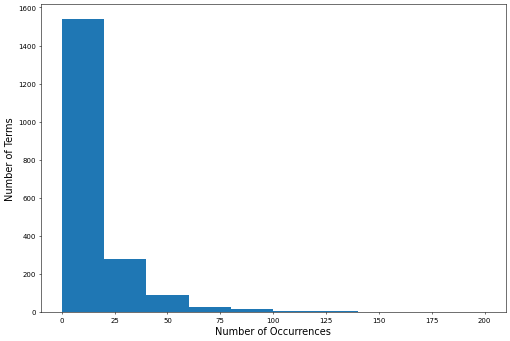

In [21]:
plt.figure(figsize = (12, 8))
plt.hist(doc_term_df.sum(axis=0).T, range=(0, 200))
plt.xlabel('Number of Occurrences',fontsize=14)
plt.ylabel('Number of Terms',fontsize=14);

In [22]:
# Re-tokenize words, recreate joined documents
corpus_df['lemmas'] = corpus_df.Text.apply(lambda x: get_lemmas(x, words_to_remove))
corpus_df['lemmas_joined'] = corpus_df.lemmas.apply(lambda x: ' '.join(x))
corpus_df.lemmas.head()

Doc_ID
191    [action, angel, fallen, disappointing, reason,...
192    [angel, fall, mark, time, gerard, butler, secr...
193    [come, time, action, franchise, long, hard, lo...
194    [ric, roman, waugh, angel, fallen, secret, ser...
195    [hollywood, ridiculous, franchise, fallen, ser...
Name: lemmas, dtype: object

## 1.5 Get Lemmatized and Filtered Sentences

In [23]:
corpus_df['sentences_lemmatized']=\
corpus_df.raw_sentences.apply(lambda x: [lemmatize_sentence(s, words_to_remove) for s in x])

In [24]:
corpus_df.head().T


Doc_ID,191,192,193,194,195
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen,TJH_Doc5_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen,TJH_Doc5_Angelhasfallen
Student Name,TJH,TJH,TJH,TJH,TJH
Genre of Movie,Action,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...,Ric Roman Waugh's Angel Has Fallen sees U.S. S...,Hollywood's most ridiculous franchise has been...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193,Action_Angel has fallen_N_194,Action_Angel has fallen_N_195
Doc_ID,191,192,193,194,195
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...,[Ric Roman Waugh's Angel Has Fallen sees U.S. ...,[Hollywood's most ridiculous franchise has bee...


## 1.6 Review by Movie

In [25]:
print(corpus_df['Movie Title'].unique())


['Angel has fallen' 'Inception' 'No time to Die' 'Taken' 'Top Gun'
 'Despicable Me 3' 'Holmes and Watson' 'Lost City' 'The Other Guys'
 'Drag me to hell' 'Fresh' 'It Chapter Two' 'Sinister' 'Us' 'Batman'
 'Equilibrium' 'Minority Report' 'Oblivion' 'Pitch Black']


In [26]:
movie_of_interest = 'Batman'

movie_df = corpus_df[corpus_df['Movie Title'] == movie_of_interest].copy()
movie_df.head(3).T

Doc_ID,281,282,283
DSI_Title,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Submission File Name,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Student Name,JWG,JWG,JWG
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Batman,Batman,Batman
Text,How many Batmen does the world need? This may ...,One thing you can say about THE BATMAN without...,"Somewhere inside *The Batman* there's a taut, ..."
Descriptor,Sci-Fi_Batman_N_281,Sci-Fi_Batman_N_282,Sci-Fi_Batman_N_283
Doc_ID,281,282,283
raw_sentences,"[How many Batmen does the world need?, This ma...",[One thing you can say about THE BATMAN withou...,"[Somewhere inside *, The Batman* there's a tau..."


# 2. Knowledge Graph Work

In [27]:
movie_of_interest = 'Batman'

movie_df = corpus_df[corpus_df['Movie Title'] == movie_of_interest].copy()
movie_df.head(3).T

Doc_ID,281,282,283
DSI_Title,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Submission File Name,JWG_Doc1_Batman,JWG_Doc2_Batman,JWG_Doc3_Batman
Student Name,JWG,JWG,JWG
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Negative,Negative,Negative
Movie Title,Batman,Batman,Batman
Text,How many Batmen does the world need? This may ...,One thing you can say about THE BATMAN without...,"Somewhere inside *The Batman* there's a taut, ..."
Descriptor,Sci-Fi_Batman_N_281,Sci-Fi_Batman_N_282,Sci-Fi_Batman_N_283
Doc_ID,281,282,283
raw_sentences,"[How many Batmen does the world need?, This ma...",[One thing you can say about THE BATMAN withou...,"[Somewhere inside *, The Batman* there's a tau..."


In [28]:
orig_corpus_text_sentences = [y for x in movie_df.raw_sentences for y in x]
lemma_corpus_text_sentences = [y for x in movie_df.sentences_lemmatized for y in x]

corpus_text_sentences = orig_corpus_text_sentences
#corpus_text_sentences = lemma_corpus_text_sentences

example_sentence = nlp(corpus_text_sentences[5])
corpus_text_sentences[5]

"That changed in 1989 with Tim Burton's *Batman*."

In [29]:
entity_pairs = [get_entities(x) for x in tqdm(corpus_text_sentences)]


100%|██████████| 234/234 [00:01<00:00, 118.93it/s]


In [30]:
entity_pairs2 = [nlp2(x) for x in tqdm(corpus_text_sentences)]

100%|██████████| 234/234 [00:02<00:00, 112.61it/s]


In [31]:
sentence = corpus_text_sentences[10]
print(sentence)

Joel Schumacher's two efforts - *Batman Forever* (1995) and *Batman & Robin* (1997)- were everything wrong with peak 1990s' Hollywood, when the studios just hurled millions of dollars and a random array of A- and B-list stars at a nonsensical screenplay and hoped there were enough explosions to distract the audience.


In [32]:
tokens = nlp2(sentence)
svos = findSVOs(tokens)
print(svos)
print(type(svos[0]))

[('the studios', 'hurled', 'millions of dollars'), ('the studios', 'hurled', 'a random array of at a nonsensical screenplay'), ('there', 'were', 'enough explosions'), ('enough explosions', 'distract', 'the audience')]
<class 'tuple'>


In [33]:
for svo in svos:
  print(svo)
  print(svo[0], svo[1])

('the studios', 'hurled', 'millions of dollars')
the studios hurled
('the studios', 'hurled', 'a random array of at a nonsensical screenplay')
the studios hurled
('there', 'were', 'enough explosions')
there were
('enough explosions', 'distract', 'the audience')
enough explosions distract


In [34]:
# Iterate over the list corpus_text_sentences
# Create a dataframe
# For each sentence in the list, do the following:
# Capture the index number for the sentence
# Tokenize the sentence using the nlp2(sentence) function
# Run the findSVOs function (findSVOs(tokens))
# The findSVOs function produces a list of tuples.  The first item in the tuple is the subject, the second is the verb, and the third is the object
# Populate each row in the dataframe with the sentence index and the subject, verb, object

# Create an empty dataframe
entities_df = pd.DataFrame(columns=['Sentence Index', 'Subject', 'Verb', 'Object'])

# Iterate over the list of sentences
for i, sentence in enumerate(corpus_text_sentences):
    # Tokenize the sentence
    tokens = nlp2(sentence)
    
    # Find subject-verb-object tuples
    svos = findSVOs(tokens)
    
    # Extract subject, verb, object from each tuple and populate the dataframe
    for svo in svos:
        subject = svo[0] if len(svo) > 0 else ""
        verb = svo[1] if len(svo) > 1 else ""
        obj = svo[2] if len(svo) > 2 else ""
        entities_df = entities_df.append({'Sentence Index': i, 'Subject': subject, 'Verb': verb, 'Object': obj}, ignore_index=True)

# Print the resulting dataframe
entities_df.head(10)

,Sentence Index,Subject,Verb,Object
0,0,the world,need,
1,1,This,seem,an odd question in the current era
2,2,Many,consider,
3,3,This,!was,the case
4,4,the world,went,
5,4,another movie,starring,the Caped Crusader
6,5,That,changed,
7,6,a unproven cult filmmaker,direct,its
8,6,achievement something of a surprise,make,The troubled production history
9,7,Warner Bros.,botched,most of the movies


In [35]:
test_word = 'Changed the world    Warner Bros.  !was'
print(get_lemmas(test_word,[]))

['change', 'the', 'world', '', 'warner', 'bros', '', '', 'be']


In [36]:
def is_negative(verb):
    return verb.startswith('!')

def get_lemma(text: str):
  return(get_lemmas(text, []))

entities_df['Negative'] = entities_df['Verb'].apply(is_negative)

# Apply the get_lemmas function to subject, verb, and object columns
#entities_df['Subject Lemma'] = entities_df['Subject'].apply(get_lemma)
#entities_df['Verb Lemma'] = entities_df['Verb'].apply(get_lemma)
#entities_df['Object Lemma'] = entities_df['Object'].apply(get_lemma)

entities_df['Subject Lemma'] = entities_df['Subject'].apply(clean_doc)
entities_df['Verb Lemma'] = entities_df['Verb'].apply(get_lemma)
entities_df['Verb Lemma'] = entities_df['Verb Lemma'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
entities_df['Object Lemma'] = entities_df['Object'].apply(clean_doc)

entities_df.head(20)

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
0,0,the world,need,,False,world,need,
1,1,This,seem,an odd question in the current era,False,This,seem,odd question current era
2,2,Many,consider,,False,Many,consider,
3,3,This,!was,the case,True,This,be,case
4,4,the world,went,,False,world,go,
5,4,another movie,starring,the Caped Crusader,False,another movie,star,Caped Crusader
6,5,That,changed,,False,That,change,
7,6,a unproven cult filmmaker,direct,its,False,unproven cult filmmaker,direct,
8,6,achievement something of a surprise,make,The troubled production history,False,achievement something surprise,make,The troubled production history
9,7,Warner Bros.,botched,most of the movies,False,Warner Bros .,botch,movie


In [37]:
test = entities_df['Verb Lemma'].apply(lambda x: type(x))
print(test)

0      <class 'str'>
1      <class 'str'>
2      <class 'str'>
3      <class 'str'>
4      <class 'str'>
           ...      
464    <class 'str'>
465    <class 'str'>
466    <class 'str'>
467    <class 'str'>
468    <class 'str'>
Name: Verb Lemma, Length: 469, dtype: object


In [38]:
print(corpus_text_sentences[3])

This was not always the case.


In [39]:
from collections import Counter
from tabulate import tabulate

# Get frequency count of unique words/tokens in Subject + Object columns
subject_object_counts = Counter(entities_df['Subject Lemma'].str.cat(entities_df['Object Lemma']).str.lower().str.split().sum())

# Get frequency count of unique words/tokens in Verb column
verb_counts = Counter(entities_df['Verb Lemma'].str.lower().str.split().sum())

# Sort the counts in descending order and select the top 30
subject_object_top = subject_object_counts.most_common(30)
verb_top = verb_counts.most_common(30)

# Prepare data for tabulate
subject_object_data = [(word, count) for word, count in subject_object_top]
verb_data = [(word, count) for word, count in verb_top]

# Print the results
print("Subject + Object Counts:")
print(tabulate(subject_object_data, headers=["Word", "Count"], tablefmt="fancy_grid"))

print("\nVerb Counts:")
print(tabulate(verb_data, headers=["Word", "Count"], tablefmt="fancy_grid"))


Subject + Object Counts:
╒═══════════╤═════════╕
│ Word      │   Count │
╞═══════════╪═════════╡
│ *         │      47 │
├───────────┼─────────┤
│ the       │      38 │
├───────────┼─────────┤
│ batman    │      35 │
├───────────┼─────────┤
│ ,         │      29 │
├───────────┼─────────┤
│ film      │      16 │
├───────────┼─────────┤
│ -         │      14 │
├───────────┼─────────┤
│ reeves    │      14 │
├───────────┼─────────┤
│ )         │      11 │
├───────────┼─────────┤
│ (         │       9 │
├───────────┼─────────┤
│ nolan     │       7 │
├───────────┼─────────┤
│ one       │       7 │
├───────────┼─────────┤
│ i         │       7 │
├───────────┼─────────┤
│ ``        │       7 │
├───────────┼─────────┤
│ movie     │       6 │
├───────────┼─────────┤
│ matt      │       6 │
├───────────┼─────────┤
│ burton    │       5 │
├───────────┼─────────┤
│ knight    │       5 │
├───────────┼─────────┤
│ gordon    │       5 │
├───────────┼─────────┤
│ scene     │       5 │
├───────────┼──

In [40]:
def find_subject(df, search_string):
    return df[df['Subject Lemma'].str.lower().str.contains(search_string.lower())]

def find_object(df, search_string):
    return df[df['Object Lemma'].str.lower().str.contains(search_string.lower())]

def find_subject_object(df, search_string):
    return df[(df['Subject Lemma'].str.lower().str.contains(search_string.lower())) | (df['Object Lemma'].str.lower().str.contains(search_string.lower()))]
    
def find_verb(df, search_string):
    return df[df['Verb Lemma'].str.lower().str.contains(search_string.lower())]

In [41]:
find_subject_object(entities_df, 'reeves')

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
168,83,Matt Reeves,is,,False,Matt Reeves,be,
177,85,""" Something in "" of Reeves new film",be,there,False,`` Something `` Reeves new film,be,
181,87,Reeves himself,said,,False,Reeves,say,
222,101,my problems with Reeves film,came,,False,problem Reeves film,come,
231,106,Reeves,give,,False,Reeves,give,
237,108,Reeves,gets,,False,Reeves,get,
240,110,Reeves,packs,,False,Reeves,pack,
252,118,Reeves,keeps,viewers,False,Reeves,keep,viewer
273,125,Reeves,subvert,this,False,Reeves,subvert,
274,125,Reeves,subvert,expectations,False,Reeves,subvert,expectation


In [42]:
find_subject_object(entities_df, 'nolan')

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
33,16,Nolan films,praised,,False,Nolan film,praise,
34,17,The Nolan trilogy,was,,False,The Nolan trilogy,be,
40,19,Nolan,mined,the Batman mythology,False,Nolan,mine,Batman mythology
45,21,the Nolan films,raked,about $ 2.4 billion,False,Nolan film,rake,$ 2.4 billion
153,75,Christopher Nolan,completed,his outstanding trilogy,False,Christopher Nolan,complete,outstanding trilogy
229,104,red)-the distinct palettes of Nolan Knight tri...,fused,,False,red ) -the distinct palette Nolan Knight trilogy,fuse,
365,170,there,'s,"the Nolan series , was",False,,be,"Nolan series ,"
392,188,"Gothic Batman Burton ) ,",grounded,Batman Nolan ),False,"Gothic Batman Burton ) ,",ground,Batman Nolan )
423,214,* * Christopher Nolan *,introduced,the world,False,* * Christopher Nolan *,introduce,world


In [178]:
find_subject_object(entities_df, 'batman')

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
20,11,There,were,Batman movies,False,There,be,Batman movie
32,16,* Batman *,hailed,,False,* Batman *,hail,
40,19,Nolan,mined,the Batman mythology,False,Nolan,mine,Batman mythology
47,21,the studio,give,Batman,False,studio,give,Batman
52,23,Ben Affleck Batman,barking,orders,False,Ben Affleck Batman,bark,order
77,34,"The hunt for , as Riddler",leads,The Batman,False,"The hunt , Riddler",lead,The Batman
84,37,The Batman,discovered,,False,The Batman,discover,
85,37,"In , Batman has discovered is .",includes,a pussy hat,False,"In , Batman discovered .",include,pussy hat
124,63,Batman presence,occurs,,False,Batman presence,occur,
133,66,her life,walk,"a hyper - masculine archetype , Batman ,",False,life,walk,"hyper - masculine archetype , Batman ,"


In [43]:
find_verb(entities_df, 'have')

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
11,8,Burton 1992 sequel * Returns *,had,a assured gothic sensibility,False,Burton 1992 sequel * Returns *,have,assured gothic sensibility
35,18,his movies,had,a sweeping grandeur,False,movie,have,sweeping grandeur
36,18,his movies,had,emotional texture,False,movie,have,emotional texture
41,19,it,had,,False,,have,
49,22,they,have,,False,,have,
50,23,we,have,the glowering,False,,have,glowering
51,23,we,have,movies like a executive,False,,have,movie like executive
80,34,everyone,has,"a good , felonious time",False,everyone,have,"good , felonious time"
161,81,one person,had,,False,one person,have,
162,81,it,have,,False,,have,


In [44]:
find_verb(entities_df, 'make')

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
8,6,achievement something of a surprise,make,The troubled production history,False,achievement something surprise,make,The troubled production history
26,14,a legacy superhero like,make,the box office,False,legacy superhero like,make,box office
27,14,a legacy superhero like,make,revenue,False,legacy superhero like,make,revenue
42,20,The trilogy,made,dramatic sense,False,The trilogy,make,dramatic sense
114,55,someone,make,a new drug,False,someone,make,new drug
156,77,it,made,perfect sense,False,,make,perfect sense
283,128,his identity as,made,,False,identity,make,
301,137,a difference,!make,he,True,difference,make,
306,141,it,making,a positive difference,False,,make,positive difference
307,142,he,making,,False,,make,


In [45]:
find_verb(entities_df, 'give')

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
22,13,the green light,give,"other comic franchises from ,",False,green light,give,"comic franchise ,"
23,13,that time,give,"other comic franchises from ,",False,time,give,"comic franchise ,"
47,21,the studio,give,Batman,False,studio,give,Batman
48,21,the studio,give,a rest,False,studio,give,rest
163,81,the standout performance of the film,give,who,False,standout performance film,give,
164,81,boss Carmine Falcone,give,who,False,bos Carmine Falcone,give,
193,93,Zack Snyder 's gloomy,gave,the Oscar winner,False,Zack Snyder 's gloomy,give,Oscar winner
194,93,Zack Snyder 's gloomy,gave,anything,False,Zack Snyder 's gloomy,give,anything
195,93,superhero melange](https://youtu.be,gave,the Oscar winner,False,superhero melange ] ( http : //youtu.be,give,Oscar winner
196,93,superhero melange](https://youtu.be,gave,anything,False,superhero melange ] ( http : //youtu.be,give,anything


In [46]:
kg_df = pd.DataFrame({'source': entities_df['Subject Lemma'], 'edge': entities_df['Verb Lemma'], 'target': entities_df['Object Lemma']})


In [182]:
sentences = [88, 150, 13, 21, 125, 215, 116, 190]

for s in sentences:
  print(corpus_text_sentences[s])

To be clear, *The Batman* has no qualms about being a comic book movie.
He has a grand vision and he cares about making sure that vision is a part of every aspect of the filmmaking process.
But other comic franchises from Blade to Spider-man, the X-Men, Hellboy, and the Incredible Hulk were given the green light in that time.
But all together, the Nolan films raked in about $2.4 billion, so there was no way the studio would give Batman a rest.
But Reeves utilizes this to subvert expectations in very much the same way [Burton does in his 1989 *Batman*](https://www.cbr.com/mcdonalds-ruined-tim-burton-third-batman-movie/).
**Reeves** has opened the floodgates on the wealth of grimdark potential lying within ***The-*
## The Batman Puts the Audience in The Riddler's Point of View *The Batman* opens on a long shot, peering through a scope into Mitchell's home.
Finally, we get a sleuthing Batman.


In [47]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [48]:
kg_df.head(20)

,source,edge,target
1,this,seem,odd question current era
3,this,be,case
5,another movie,star,caped crusader
8,achievement something surprise,make,the troubled production history
9,warner bros .,botch,movie
11,burton 1992 sequel * returns *,have,assured gothic sensibility
12,devito best effort,cackle,villainy
13,devito best effort,purr,villainy
14,devito best effort,purr,villainy
16,studio,hurl,million dollar


In [49]:
kg_df.head(6).T


,1,3,5,8,9,11
source,this,this,another movie,achievement something surprise,warner bros .,burton 1992 sequel * returns *
edge,seem,be,star,make,botch,have
target,odd question current era,case,caped crusader,the troubled production history,movie,assured gothic sensibility


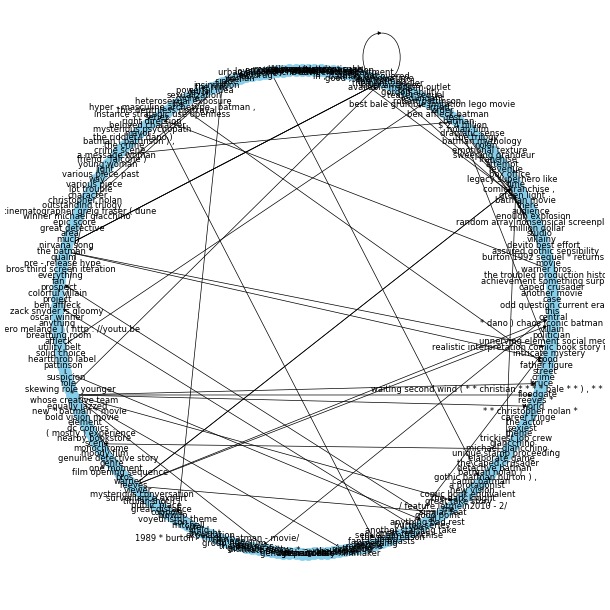

In [50]:
plot_graph(kg_df, use_circular=True)


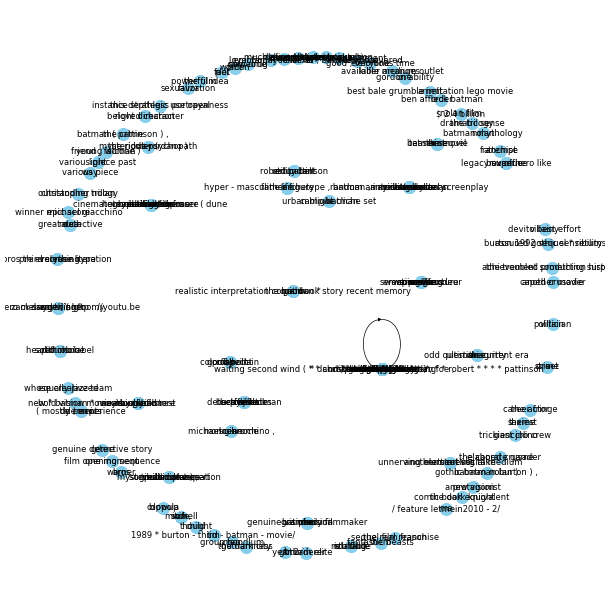

In [51]:
plot_graph(kg_df, use_circular=False)


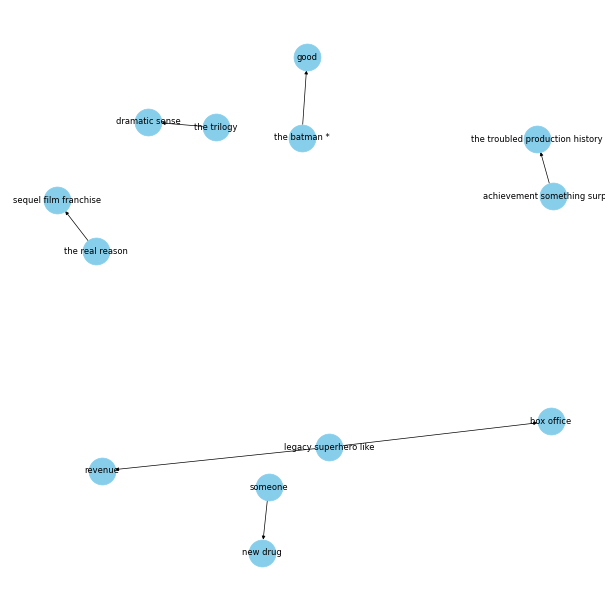

In [52]:
RELATION_TO_EXPLORE = 'make'
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

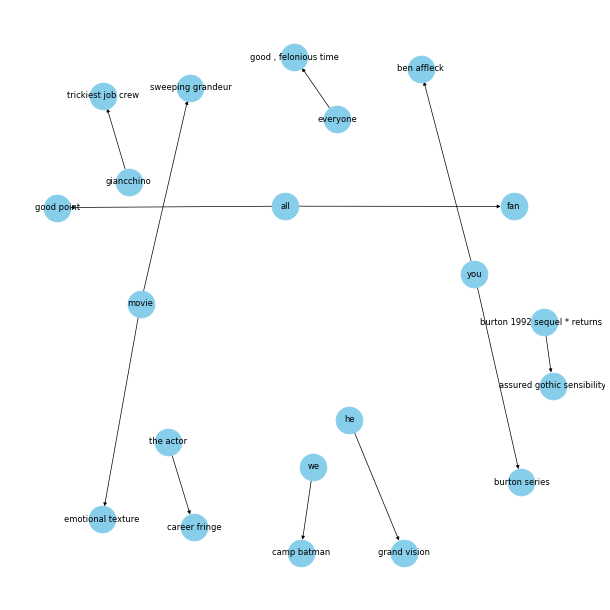

In [53]:
RELATION_TO_EXPLORE = 'have'
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

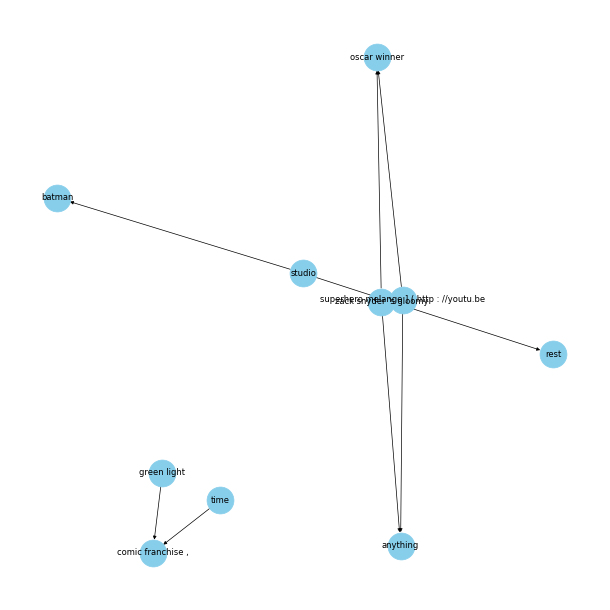

In [54]:
RELATION_TO_EXPLORE = 'give'
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

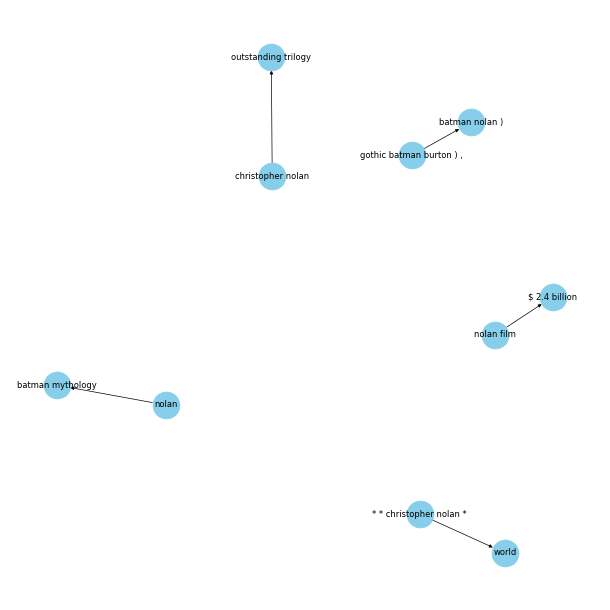

In [55]:
ENTITY_TO_EXPLORE = 'nolan'
entity_filter = kg_df['source'].str.contains(ENTITY_TO_EXPLORE, case=False) | kg_df['target'].str.contains(ENTITY_TO_EXPLORE, case=False)
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


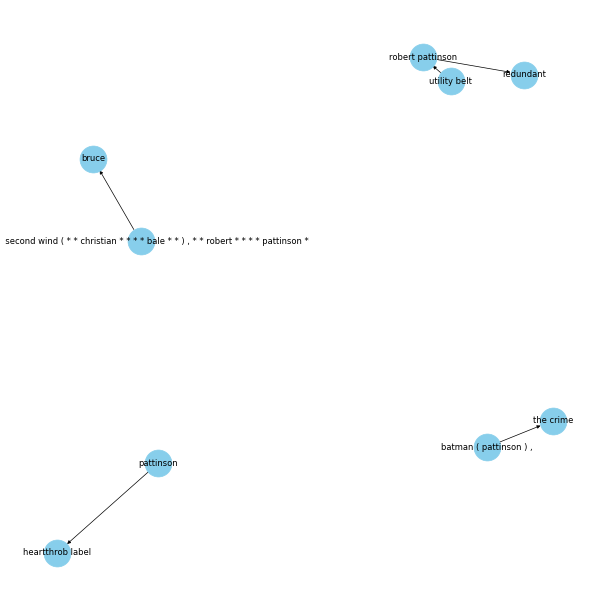

In [56]:
ENTITY_TO_EXPLORE = 'pattinson'
entity_filter = kg_df['source'].str.contains(ENTITY_TO_EXPLORE, case=False) | kg_df['target'].str.contains(ENTITY_TO_EXPLORE, case=False)
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


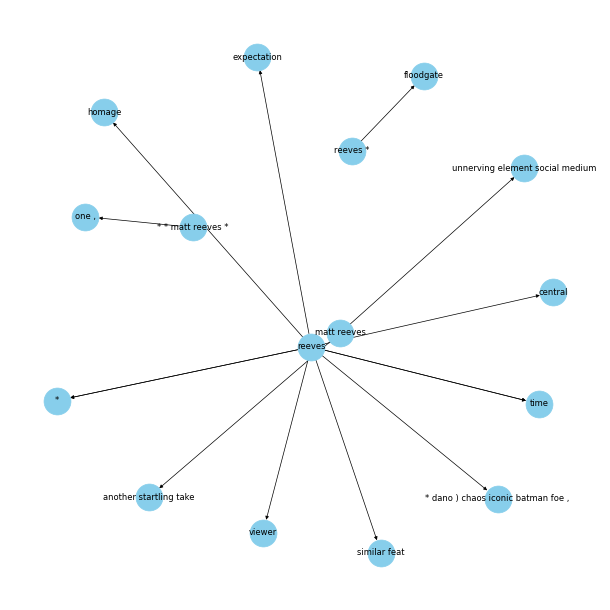

In [57]:
ENTITY_TO_EXPLORE = 'reeves'
entity_filter = kg_df['source'].str.contains(ENTITY_TO_EXPLORE, case=False) | kg_df['target'].str.contains(ENTITY_TO_EXPLORE, case=False)
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


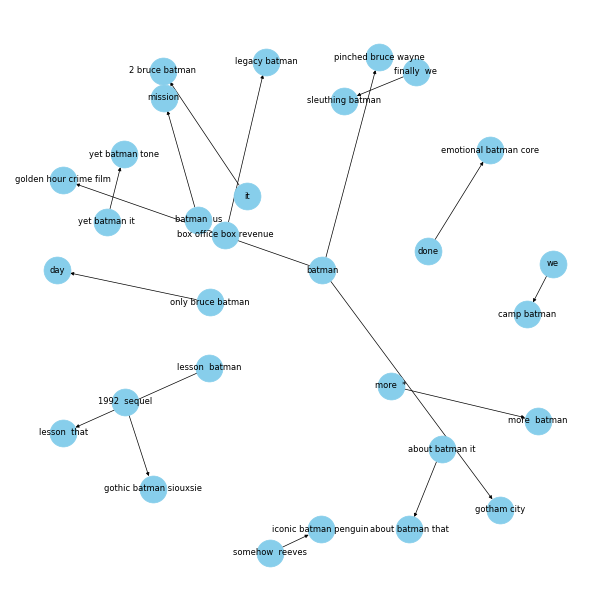

In [183]:
ENTITY_TO_EXPLORE = 'batman'
entity_filter = kg_df['source'].str.contains(ENTITY_TO_EXPLORE, case=False) | kg_df['target'].str.contains(ENTITY_TO_EXPLORE, case=False)
G = nx.from_pandas_edgelist(kg_df[entity_filter], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()


## Intentionally Blank.  Below this is using the legacy code provided by TA that doesn't work very well

In [58]:
entity_pairs

[['many  world', 'many  Batmen'],
 ['This', 'current  era'],
 ['answer', ''],
 ['This', ''],
 ['world', 'decades Caped Crusader'],
 ['That', 'Tim *'],
 ['its', 'unproven blockbuster surprise'],
 ['that', 'movies'],
 ['1992  sequel', 'gothic Batman Siouxsie'],
 ['best Danny it', 'strange Prince soundtrack'],
 ['when peak studios', 'enough B audience'],
 ['', 'eight Batman years'],
 ['world', ''],
 ['comic  franchises', 'green Spider time'],
 ['box office box revenue', 'legacy Batman'],
 ['2005 Dark Knight', 'finally Christopher Nolan trilogy'],
 ['aware Adam West films', 'hearted  camp'],
 ['Nolan trilogy', ''],
 ['Still  movies', 'strenuous Zack efforts'],
 ['about Batman it', 'about Batman that'],
 ['trilogy', 'ending DC overs'],
 ['$ 2.4 studio', 'rest'],
 ['Even  they', ''],
 ['corporate Zack Snyder who', 'day cable news'],
 ['Arnett', 'grumble Lego movies'],
 ['Robert Pattinson', 'most  redundant'],
 ['you', 'it'],
 ['this', 'rebooted DC franchise'],
 ['', ''],
 ['black  interpreta

In [59]:
print(type(entity_pairs))

<class 'list'>


In [60]:
relations = [get_relation(x) for x in corpus_text_sentences]   
#extract subject and object
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]
kg_df = pd.DataFrame({'source': source, 'edge': relations, 'target': target})

In [61]:
kg_df.head(20)

,source,edge,target
0,many world,need,many Batmen
1,This,seem,current era
2,answer,be enough,
3,This,was,
4,world,went,decades Caped Crusader
5,That,changed in,Tim *
6,its,directed by,unproven blockbuster surprise
7,that,was,movies
8,1992 sequel,had,gothic Batman Siouxsie
9,best Danny it,missed,strange Prince soundtrack


## 2.2 Prep Data for Knowledge Graphing

In [62]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [63]:
kg_df.head(20)

,source,edge,target
0,many world,need,many batmen
1,this,seem,current era
4,world,went,decades caped crusader
5,that,changed in,tim *
6,its,directed by,unproven blockbuster surprise
7,that,was,movies
8,1992 sequel,had,gothic batman siouxsie
9,best danny it,missed,strange prince soundtrack
10,when peak studios,efforts,enough b audience
13,comic franchises,given,green spider time


In [64]:
kg_df.head(6).T


,0,1,4,5,6,7
source,many world,this,world,that,its,that
edge,need,seem,went,changed in,directed by,was
target,many batmen,current era,decades caped crusader,tim *,unproven blockbuster surprise,movies


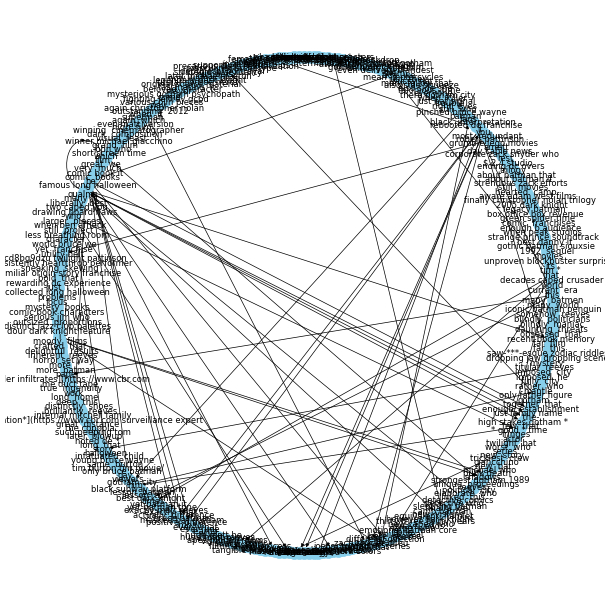

In [65]:
plot_graph(kg_df, use_circular=True)


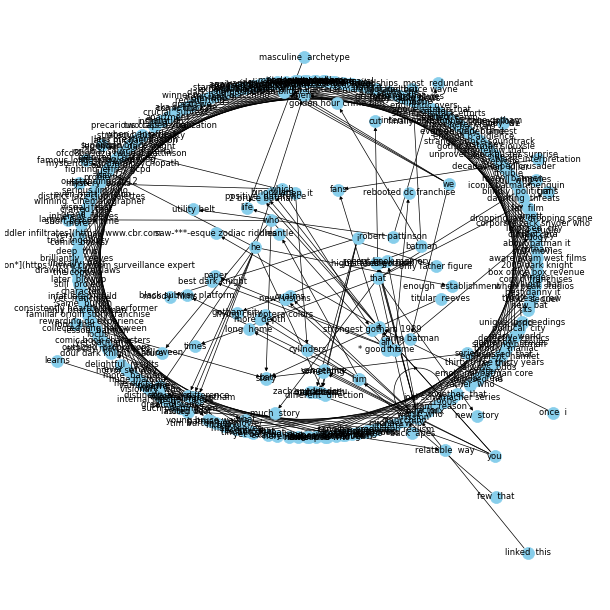

In [66]:
plot_graph(kg_df, use_circular=False)


In [67]:
kg_df['edge'].value_counts()[:50]


is                25
's                11
was               10
have               7
are                5
has                3
had                3
need               2
seem               2
think              2
seen               2
provides           2
get                2
brought            2
introduced         1
created            1
brings             1
are top            1
is spectacular     1
proves             1
is exceptional     1
misses             1
is about           1
makes good         1
making             1
invested in        1
telling            1
's unavoidable     1
been               1
walking out        1
veers into         1
talks about        1
pays               1
utilizes           1
conjures           1
taken              1
aligning           1
go                 1
pulling from       1
sustained long     1
're                1
is untouchable     1
'm                 1
happens            1
opened             1
watched            1
left behind        1
*            

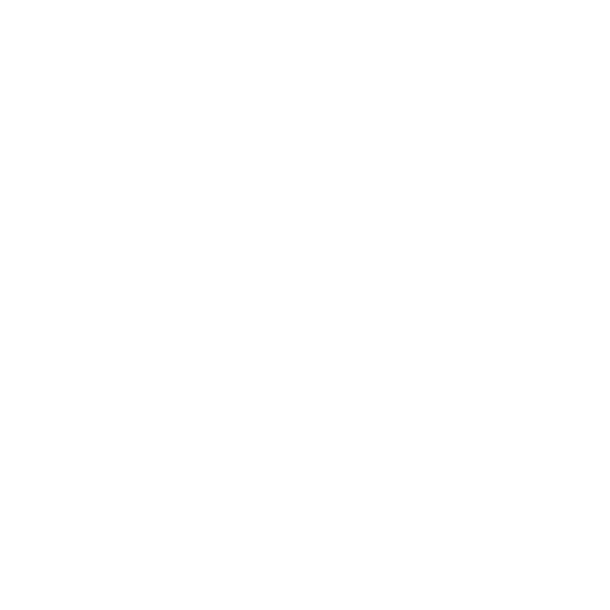

In [68]:
RELATION_TO_EXPLORE = 'tell'
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE], 
                            "source", "target", 
                            edge_attr=True, 
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True, 
        node_color='skyblue', 
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [69]:
kg_df['target'].value_counts()[:50]


it                             3
life                           2
fans                           2
story                          2
*                              2
bat                            2
them                           2
many  batmen                   1
filmmaking process             1
what                           1
huge matt reeves               1
apes monster films             1
visually  story                1
much  story                    1
tangible production realism    1
most  movies                   1
impact                         1
more  depth                    1
theatre                        1
relatable  way                 1
vengeance                      1
something                      1
mission                        1
new  mix                       1
ever  line                     1
masked bat gotham              1
positive  difference           1
extant  reason                 1
distinctly  shoes              1
internal mitchell family       1
great  dis

In [70]:
pd.concat([kg_df['source'], kg_df['target']]).value_counts()[:50]


*                                    12
he                                    8
that                                  7
it                                    7
you                                   5
this                                  4
who                                   4
we                                    4
i                                     4
batman                                3
him                                   3
story                                 2
bat                                   2
what                                  2
when  it                              2
them                                  2
fans                                  2
robert pattinson                      2
which                                 2
life                                  2
consistently heartthrob performer     1
familiar origin story franchise       1
many  world                           1
utility belt                          1
yet  franchise                        1


In [71]:
find_sources_and_targets_with_patterns(['reeves'], kg_df)

,source,edge,target
108,inherent reeves,'s,horror set way
118,brilliantly reeves,keeps,internal mitchell family
136,exactly matt reeves,is,exactly that
146,huge matt he,misses,huge matt reeves
167,matt reeves,brought,extant reason
176,here reeves,performed,similar feat
194,reeves,wastes,unique proceedings
225,titular reeves,makes good,story
232,somehow reeves,manages,iconic batman penguin


In [175]:
find_sources_and_targets_with_patterns(['batman'], kg_df)

,source,edge,target
8,1992 sequel,had,gothic batman siouxsie
14,box office box revenue,meant,legacy batman
19,about batman it,felt,about batman that
30,batman,is,pinched bruce wayne
46,batman,'s,golden hour crime film
110,more *,is,more batman
126,only bruce batman,is,day
128,batman,talks about,gotham city
131,lesson batman,'s unavoidable,lesson that
135,yet batman it,created,yet batman tone


In [173]:
print(kg_df[kg_df['edge'] == "have"])

                        source  edge                       target
23   corporate zack snyder who  have               day cable news
81                    john who  have            short screen time
168                recent  you  have                        1960s
169            tim burton that  have       joel schumacher series
171                        you  have             zach snyder dceu
173                        all  have                         fans
226                    mystery  have  dropping jaw dropping scene


In [73]:
print(kg_df[kg_df['edge'] == "is"])

                    source edge                    target
26                     you   is                        it
29   black  interpretation   is                      fans
30                  batman   is       pinched bruce wayne
31              still  who   is               right  eyes
49                  anyone   is   standard issue backdrop
67    depthless  portrayal   is    strategic  bisexuality
70     titular source hero   is  original source material
107          crafted  that   is       delightful  results
110                more  *   is              more  batman
111                   this   is                     paper
126      only bruce batman   is                       day
132                   this   is          best dark knight
136    exactly matt reeves   is             exactly  that
145                 learns   is                      what
165               film you   is                  new  mix
174                     he   is      different  direction
178           

In [176]:
print(corpus_text_sentences[23])

Now we have the glowering Ben Affleck Batman barking orders at his fellow Justice Leaguers in the Zack Snyder movies like a retired corporate executive who now spends all day at the gym yelling at cable news.


In [177]:
entities_df[entities_df['Sentence Index']==23]

,Sentence Index,Subject,Verb,Object,Negative,Subject Lemma,Verb Lemma,Object Lemma
50,23,we,have,the glowering,False,,have,glowering
51,23,we,have,movies like a executive,False,,have,movie like executive
52,23,Ben Affleck Batman,barking,orders,False,Ben Affleck Batman,bark,order
53,23,a executive,retired,,False,executive,retire,
54,23,who,spends,,False,,spend,
55,23,a executive,yelling,,False,executive,yell,


In [75]:
rows = [95, 210, 221]
for row in rows:
  print(orig_corpus_text_sentences[row])

At some point, Affleck left the project and Robert Pattinson was tapped to strap on the utility belt.
The actor left behind the tentpoles to have a career on the fringes.
This is not the Batman that cinema-goers are used to-he is not as sure-footed in his humanity as previous adaptations, nor is he ready to embrace having genuine connections with anyone in his orbit-even Alfred Pennyworth (**Andy** **Serkis**), the only father figure left in his life.


# 2.5 Using Enhanced Subject Verb Object Extraction

# 3. RNN for Predicting Sentiment and Genre

## 3.0 Prep Data

In [76]:
datafull=corpus_df.copy() 
datafull.reset_index(drop=True, inplace=True)
datafull.head(4).T

,0,1,2,3
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Student Name,TJH,TJH,TJH,TJH
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy, dopey action bonanza ""Angel Has Fa...","""Angel Has Fallen"" marks the third time that G...",There comes a time when every action franchise...,Ric Roman Waugh's Angel Has Fallen sees U.S. S...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193,Action_Angel has fallen_N_194
Doc_ID,191,192,193,194
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...,[Ric Roman Waugh's Angel Has Fallen sees U.S. ...


In [77]:
datafull['Text'] = datafull['Text'].apply(lambda x :clean_doc(x))
datafull.head(4).T

,0,1,2,3
DSI_Title,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Submission File Name,TJH_Doc1_Angelhasfallen,TJH_Doc2_Angelhasfallen,TJH_Doc3_Angelhasfallen,TJH_Doc4_Angelhasfallen
Student Name,TJH,TJH,TJH,TJH
Genre of Movie,Action,Action,Action,Action
Review Type (pos or neg),Negative,Negative,Negative,Negative
Movie Title,Angel has fallen,Angel has fallen,Angel has fallen,Angel has fallen
Text,"The sleepy , dopey action bonanza `` Angel Has...",`` Angel Has Fallen `` mark third time Gerard ...,There come time every action franchise take lo...,Ric Roman Waugh 's Angel Has Fallen see U.S. S...
Descriptor,Action_Angel has fallen_N_191,Action_Angel has fallen_N_192,Action_Angel has fallen_N_193,Action_Angel has fallen_N_194
Doc_ID,191,192,193,194
raw_sentences,"[The sleepy, dopey action bonanza ""Angel Has F...","[""Angel Has Fallen"" marks the third time that ...",[There comes a time when every action franchis...,[Ric Roman Waugh's Angel Has Fallen sees U.S. ...


In [78]:
data = datafull[['Text','Genre of Movie', 'Review Type (pos or neg)']].copy()

data['Genre of Movie'] = data['Genre of Movie'].astype("category")
data['Genre of Movie code'] = data['Genre of Movie'].cat.codes

data['Sentiment'] = data['Review Type (pos or neg)'].apply(lambda x: 1 if x == 'Positive' else 0)

data.tail().T

,185,186,187,188,189
Text,I n't like lament changing tide cinematic land...,"When Pitch Black first hit theater , I immedia...","It 's Vin Diesel week ! Suddenly , largely unk...",Pitch Black sci-fi/horror flick merchant vesse...,A passenger spaceship hit rogue asteroid comet...
Genre of Movie,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi,Sci-Fi
Review Type (pos or neg),Positive,Positive,Positive,Positive,Positive
Genre of Movie code,3,3,3,3,3
Sentiment,1,1,1,1,1


In [79]:
features, targets = data['Text'], data['Genre of Movie code']                                                                         
data[["Genre of Movie","Genre of Movie code", 'Sentiment']].value_counts()

Genre of Movie  Genre of Movie code  Sentiment
Action          0                    0            25
                                     1            25
Horror          2                    0            25
                                     1            25
Sci-Fi          3                    0            25
                                     1            25
Comedy          1                    0            20
                                     1            20
dtype: int64

### 3.0.3 Split Train/Test/Val

In [80]:
trainds, valds, testds = get_dataset_partitions_pd(data[['Text','Genre of Movie code', 'Sentiment']])
trainds.shape, valds.shape, testds.shape

((152, 3), (19, 3), (19, 3))

### 3.0.4 Convert to Tensorflows

In [81]:
# train X & y
train_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Text'].values, tf.string)
) 
train_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Genre of Movie code'].values, tf.int64),
  ) 
train_sen_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(trainds['Sentiment'].values, tf.int64),
  ) 
# test X & y
test_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Text'].values, tf.string)
) 
test_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Genre of Movie code'].values, tf.int64),
)
test_sen_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(testds['Sentiment'].values, tf.int64),
)
#val X & Y
val_text_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Text'].values, tf.string)
) 
val_cat_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Genre of Movie code'].values, tf.int64),
)
val_sen_ds_raw = tf.data.Dataset.from_tensor_slices(
            tf.cast(valds['Sentiment'].values, tf.int64),
)

### 3.0.6 Create Modeling Datasets

In [82]:
train_ds_cat = tf.data.Dataset.zip((train_text_ds_raw, train_cat_ds_raw))
train_ds_sen = tf.data.Dataset.zip((train_text_ds_raw, train_sen_ds_raw))

test_ds_cat = tf.data.Dataset.zip((test_text_ds_raw, test_cat_ds_raw))
test_ds_sen = tf.data.Dataset.zip((test_text_ds_raw, test_sen_ds_raw))

val_ds_cat = tf.data.Dataset.zip((val_text_ds_raw, val_cat_ds_raw))
val_ds_sen = tf.data.Dataset.zip((val_text_ds_raw, val_sen_ds_raw))

### 3.0.7 Create Pipelines

In [83]:
batch_size = 3
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size=train_ds_cat.cardinality().numpy()

train_ds_cat = train_ds_cat.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

train_ds_sen = train_ds_sen.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds_cat = test_ds_cat.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

test_ds_sen = test_ds_sen.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

val_ds_cat = val_ds_cat.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

val_ds_sen = val_ds_sen.shuffle(buffer_size=buffer_size)\
                   .batch(batch_size=batch_size,drop_remainder=True)\
                   .cache()\
                   .prefetch(AUTOTUNE)

## 3.1 Create Encoder

In [84]:
VOCAB_SIZE=5000
encoder_5000 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder_5000.adapt(train_ds_cat.map(lambda text, label: text), batch_size= None)

In [85]:
VOCAB_SIZE=7000
encoder_7000 = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE, standardize="lower_and_strip_punctuation", pad_to_max_tokens= True)
encoder_7000.adapt(train_ds_cat.map(lambda text, label: text), batch_size= None)

In [86]:
vocab_5000 = np.array(encoder_5000.get_vocabulary())
len(vocab_5000)

5000

In [87]:
vocab = np.array(encoder_5000.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 's', 'the', 'film', 'movie', 'nt', 'i', 'one', 'like',
       'it', 'time', 'but', 'character', 'even', 'get', 'also', 'make',
       'way', 'story'], dtype='<U70')

In [88]:
vocab[-20:]

array(['voracious', 'vomiting', 'volleyball', 'vogue', 'vocabulary',
       'vivid', 'vitality', 'visualeffects', 'vista', 'visitor',
       'visited', 'visitation', 'visibly', 'visceral', 'virus',
       'virtually', 'virginity', 'virginal', 'viper', 'violin'],
      dtype='<U70')

In [89]:
encoded_example = encoder_5000('encanto we dont talk about bruno no no').numpy()
encoded_example[:]

array([  1, 143,   1, 646,   1,   1, 193, 193])

In [90]:
for example, label in train_ds_cat.take(1):
  print('texts: ', example.numpy()[:1])
  print()

texts:  [b"In review `` It `` 2017 , I clearly stated I liked setting event taking place term location time . I also explained I liked character , plot message film much . However , I recorded reservation sequence event classification film inside world horror . For It Chapter 2 I 'm afraid I 'm gon na move everything reservation box , maybe slight exception horror unexpected utilisation comedy . 27 year event It chapter 1 , monster awakens . Pennywise clown reappears get detected Mike ; The member loser club actually remained Derry , sole purpose studying terminate Pennywise alarm others soon appears . Mike contact rest gang come back honor oath , time Pennywise much stronger prepared challenge loser . Chapter 2 described messy get organized go back worst mess I imagine . We start event character never see throughout entire film . Then spend lot time struggle decision , everybody , including character , knew conclusion , finally horror begin . Oh yeah , get see real horror second half 

## 3.2 Category Modeling

We're going to permute:

* S1 or S2: Two model structures.  64 --> 32 and 128-->64-->32
* V1 or V2: Size of vocabulary embedded.  5k vs 7k
* D1 or D2: Two dropout values.  30% and 50%

Models will be encoded as cat_SVD, e.g., cat_111 for the first of all

### 3.2.0 Setup

In [91]:
num_classes = 4
model_cat = 'Model Cat'

train_ds = train_ds_cat
test_ds = test_ds_cat
val_ds = val_ds_cat

CLASSES_LIST = ['Action','Comedy','Horror','Sci Fi']


### 3.2.1 Cat_111

In [92]:
%%time
run = True

model_code = '111'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  cat111=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat111

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 37s 464ms/step - loss: 1.3862 - accuracy: 0.2800 - val_loss: 1.3661 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 19s 372ms/step - loss: 1.2445 - accuracy: 0.4400 - val_loss: 1.1499 - val_accuracy: 0.4444
Epoch 3/200
50/50 [==============================] - 18s 369ms/step - loss: 1.1392 - accuracy: 0.6400 - val_loss: 1.2705 - val_accuracy: 0.5556
Epoch 4/200
50/50 [==============================] - 19s 377ms/step - loss: 0.5463 - accuracy: 0.8067 - val_loss: 0.7947 - val_accuracy: 0.6667
Epoch 5/200
50/50 [==============================] - 19s 379ms/step - loss: 0.1403 - accuracy: 0.9600 - val_loss: 0.5598 - val_accuracy: 0.8889
Epoch 6/200
50/50 [==============================] - 18s 370ms/step - loss: 0.0737 - accuracy: 0.9933 - val_loss: 1.0232 - val_accuracy: 0.5556
Epoch 7/200
50/50 [==============================] - 19s 372ms/step - loss: 0.0498 - accuracy: 0.9867 - val_loss: 2.4106 - val_accuracy:

In [93]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [94]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 72ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat111')

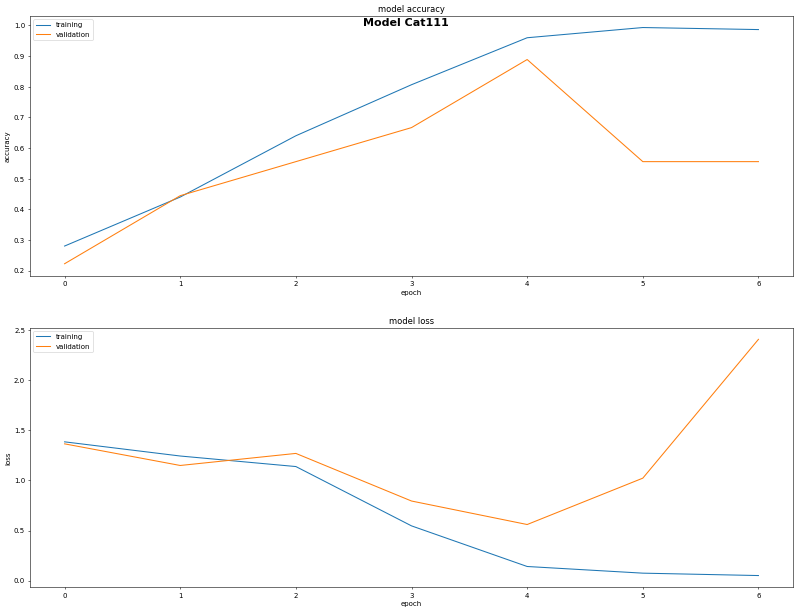

In [95]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 6s 99ms/step


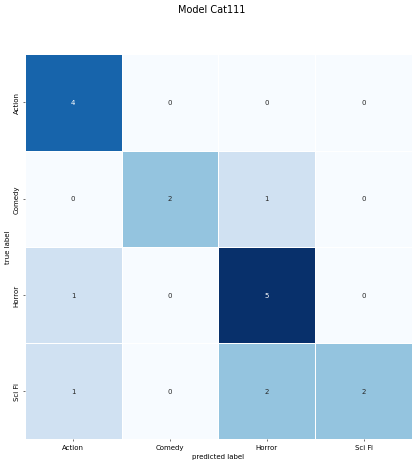

In [96]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_112

In [97]:
%%time
run = False

model_code = '112'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  cat112=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat112

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [99]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 103ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat112')

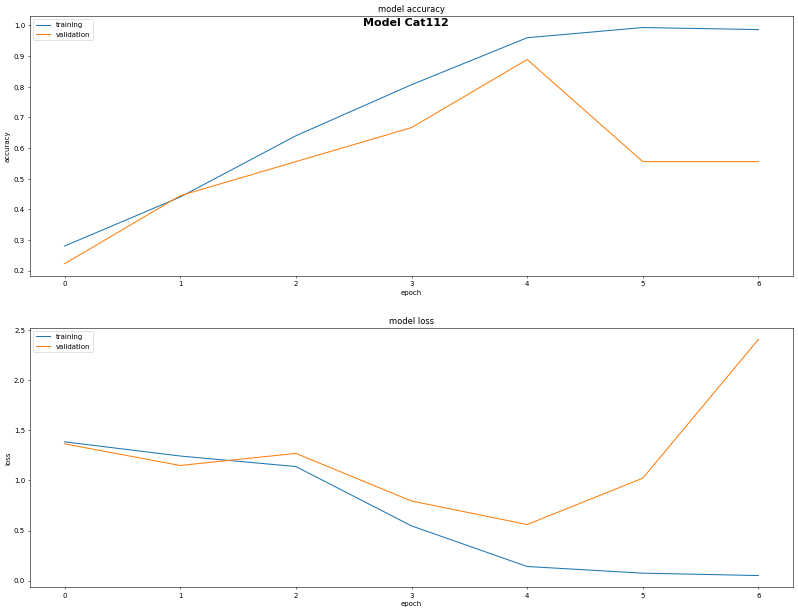

In [100]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 1s 93ms/step


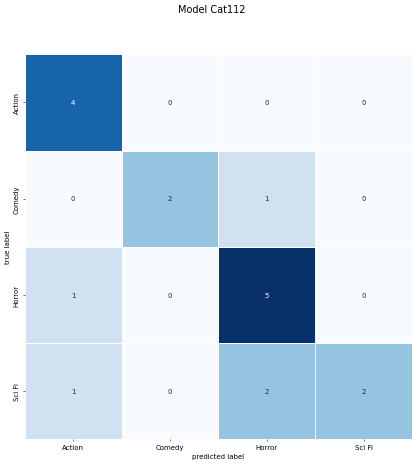

In [101]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Cat_121

In [102]:
%%time
run = False

model_code = '121'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  cat121=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat121

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.34 µs


In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [104]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 89ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat121')

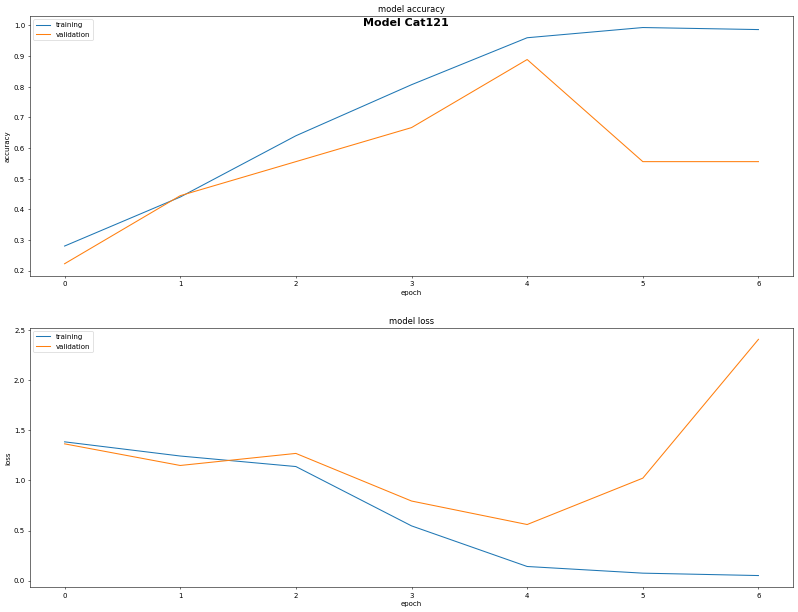

In [105]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 1s 87ms/step


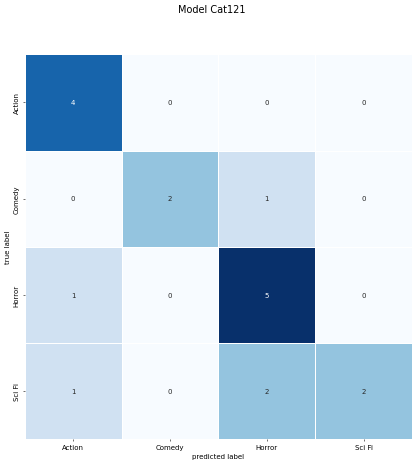

In [106]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_122

In [107]:
%%time
run = False

model_code = '122'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  cat122=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat122

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 9.54 µs


In [108]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [109]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 98ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat122')

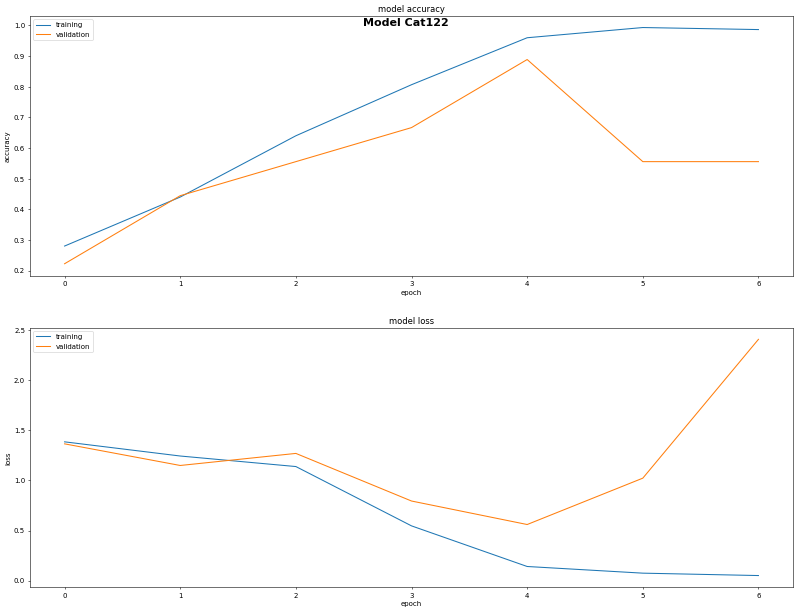

In [110]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 1s 86ms/step


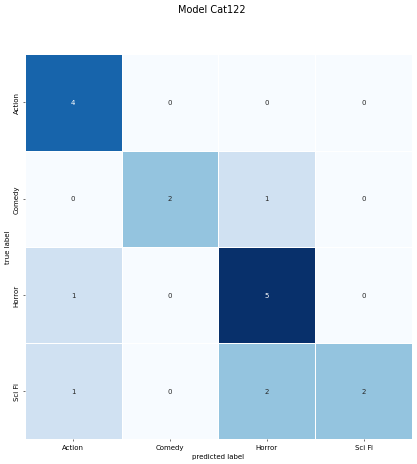

In [111]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Cat_211

In [112]:
%%time
run = False

model_code = '211'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  cat211=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat211

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.82 µs


In [113]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [114]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 108ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat211')

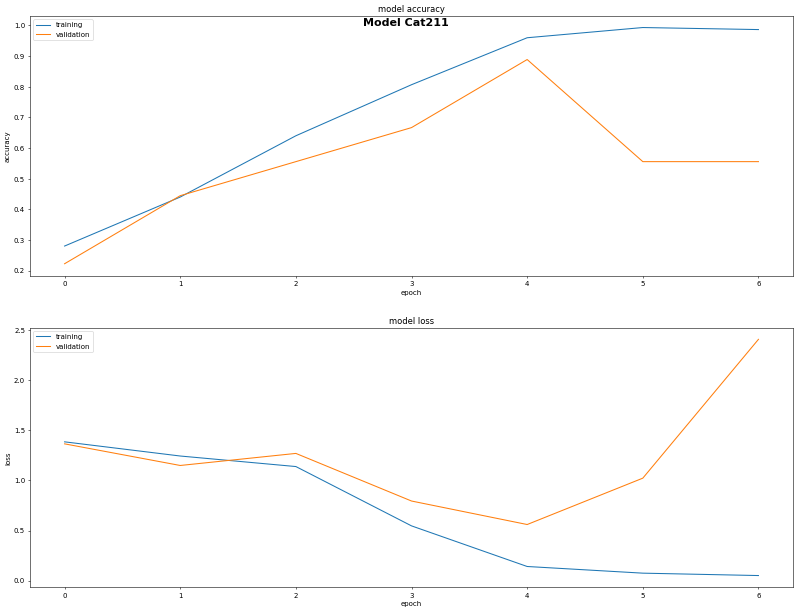

In [115]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 1s 81ms/step


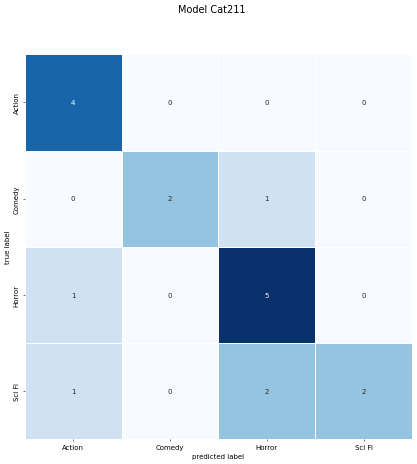

In [116]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_212

In [117]:
%%time
run = False

model_code = '212'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  cat212=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat212

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


In [118]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [119]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 100ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat212')

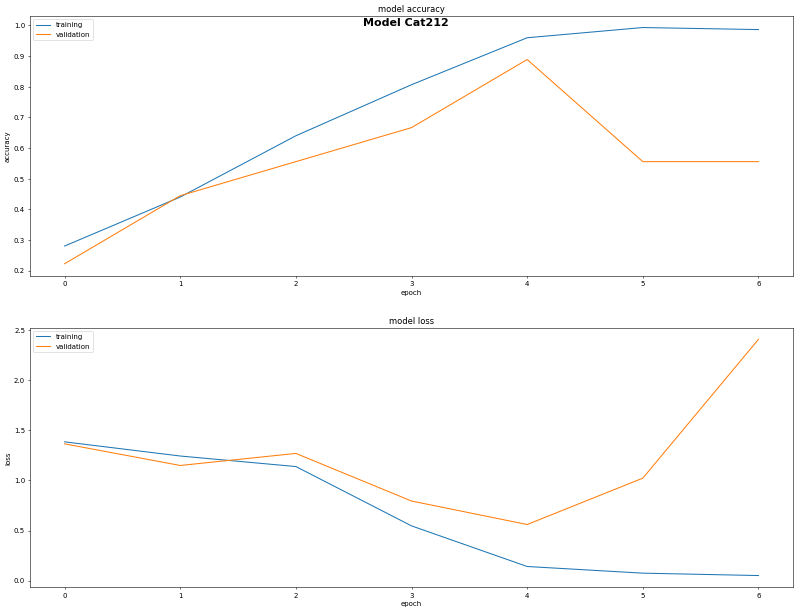

In [120]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 1s 105ms/step


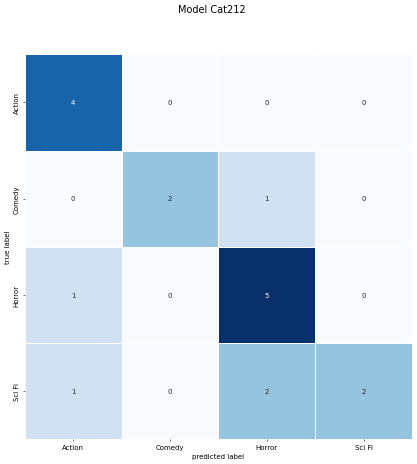

In [121]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Cat_221

In [122]:
%%time
run = False

model_code = '221'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  cat221=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat221

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [123]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [124]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 93ms/step - loss: 1.4792 - accuracy: 0.7222
Test Loss: 1.4792124032974243
Test Accuracy: 0.7222222089767456


Text(0.5, 0.98, 'Model Cat221')

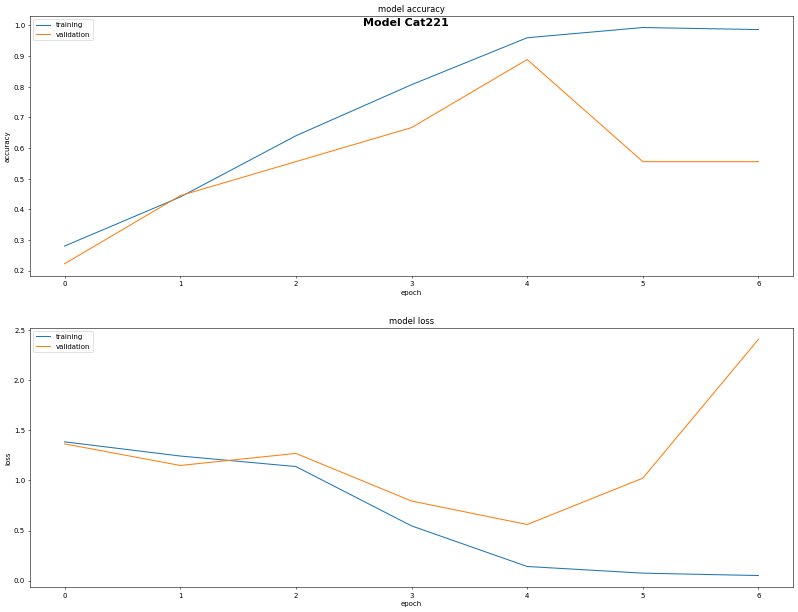

In [125]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 1s 99ms/step


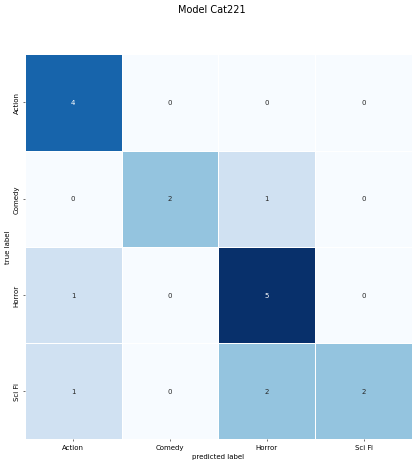

In [126]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Cat_222

In [127]:
%%time
run = True

model_code = '222'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  cat222=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = cat222

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 66s 859ms/step - loss: 1.3892 - accuracy: 0.2467 - val_loss: 1.4106 - val_accuracy: 0.1111
Epoch 2/200
50/50 [==============================] - 34s 675ms/step - loss: 1.1886 - accuracy: 0.5133 - val_loss: 1.4647 - val_accuracy: 0.2222
Epoch 3/200
50/50 [==============================] - 34s 674ms/step - loss: 0.4336 - accuracy: 0.8800 - val_loss: 1.0398 - val_accuracy: 0.6667
Epoch 4/200
50/50 [==============================] - 34s 677ms/step - loss: 0.2692 - accuracy: 0.9267 - val_loss: 1.8904 - val_accuracy: 0.2222
Epoch 5/200
50/50 [==============================] - 34s 674ms/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.7557 - val_accuracy: 0.7778
Epoch 6/200
50/50 [==============================] - 34s 686ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.4263 - val_accuracy: 0.5556
Epoch 7/200
50/50 [==============================] - 34s 678ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.5111 - val_accuracy:

In [128]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         896000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [129]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 117ms/step - loss: 1.0414 - accuracy: 0.6111
Test Loss: 1.041418433189392
Test Accuracy: 0.6111111044883728


Text(0.5, 0.98, 'Model Cat222')

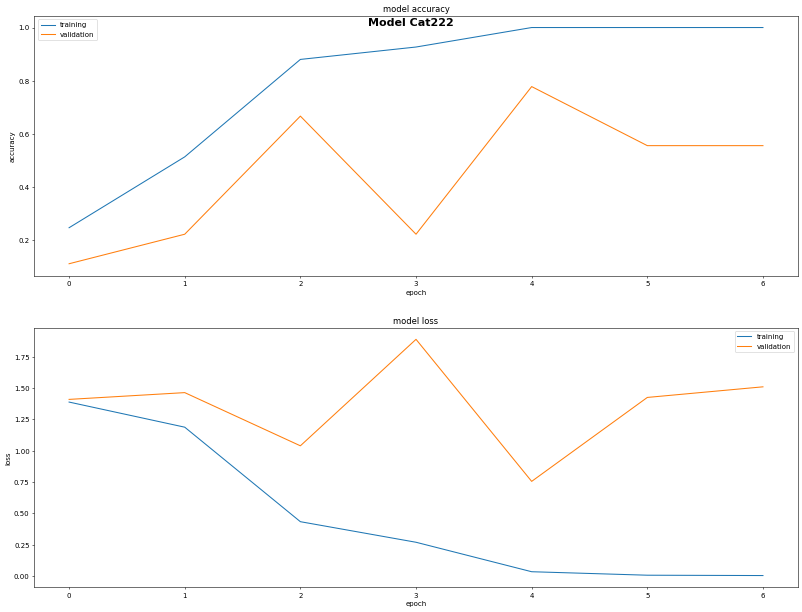

In [130]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 7s 118ms/step


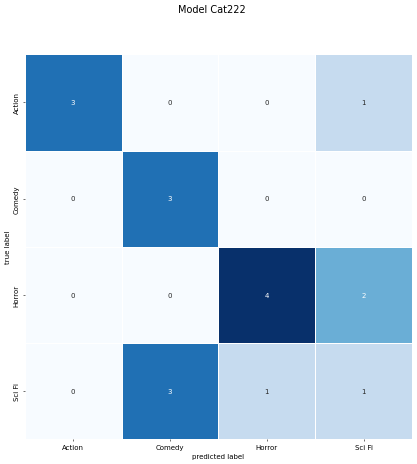

In [131]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

## 3.3 Sentiment Modeling

We're going to permute:

* S1 or S2: Two model structures.  64 --> 32 and 128-->64-->32
* V1 or V2: Size of vocabulary embedded.  5k vs 7k
* D1 or D2: Two dropout values.  30% and 50%

Models will be encoded as sen_SVD, e.g., cat_111 for the first of all

# 3.3.0 Setup

In [132]:
num_classes = 2
model_cat = 'Model Sen'

train_ds = train_ds_sen
test_ds = test_ds_sen
val_ds = val_ds_sen

CLASSES_LIST = ['Neg', 'Pos']


### 3.2.1 Sen_111

In [133]:
%%time
run = True

model_code = '111'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  sen111=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen111

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 37s 462ms/step - loss: 0.6956 - accuracy: 0.4667 - val_loss: 0.6942 - val_accuracy: 0.4444
Epoch 2/200
50/50 [==============================] - 18s 368ms/step - loss: 0.6104 - accuracy: 0.6733 - val_loss: 0.7874 - val_accuracy: 0.5556
Epoch 3/200
50/50 [==============================] - 19s 371ms/step - loss: 0.1146 - accuracy: 0.9667 - val_loss: 0.9127 - val_accuracy: 0.7778
Epoch 4/200
50/50 [==============================] - 19s 376ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.5296 - val_accuracy: 0.6667
Epoch 5/200
50/50 [==============================] - 18s 369ms/step - loss: 5.4506e-04 - accuracy: 1.0000 - val_loss: 1.6121 - val_accuracy: 0.6667
CPU times: user 5min 19s, sys: 11.4 s, total: 5min 30s
Wall time: 1min 58s


In [134]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [135]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 74ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen111')

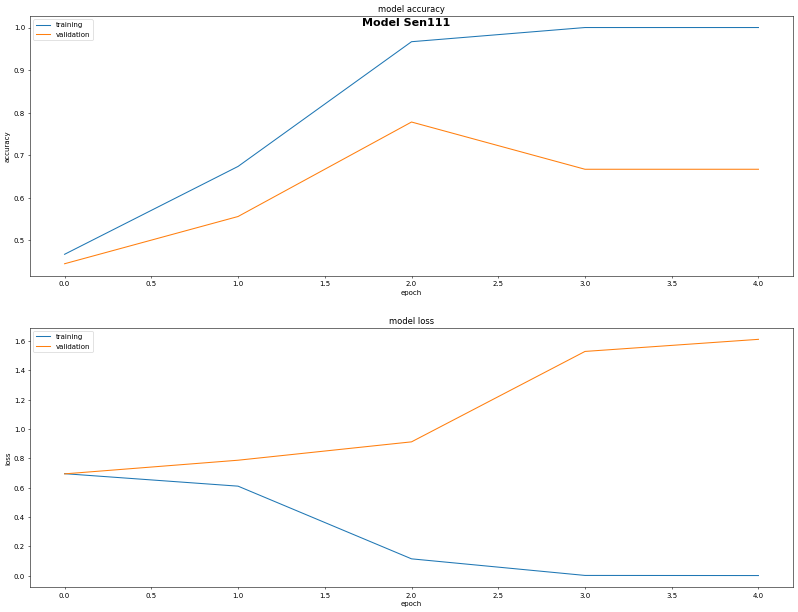

In [136]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 5s 72ms/step


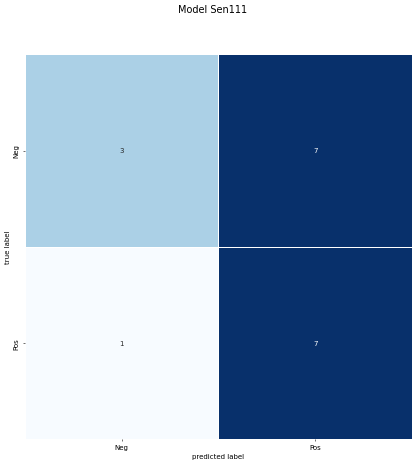

In [137]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.3.2 Sen_112

In [138]:
%%time
run = False

model_code = '112'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  sen112=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen112

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 9.78 µs


In [139]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [140]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 73ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen112')

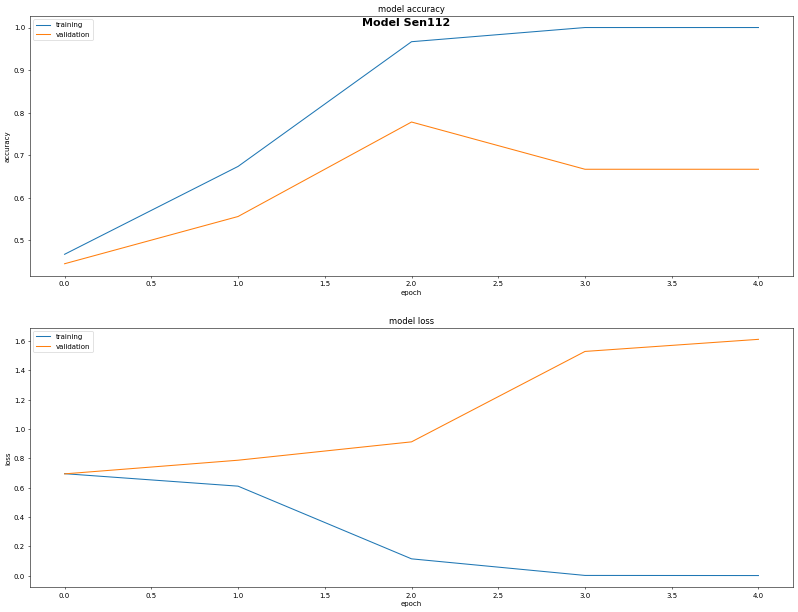

In [141]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 0s 70ms/step


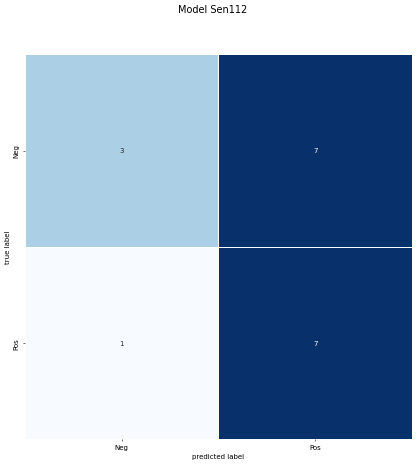

In [142]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Sen_121

In [143]:
%%time
run = False

model_code = '121'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  sen121=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen121

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 9.54 µs


In [144]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [145]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 71ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen121')

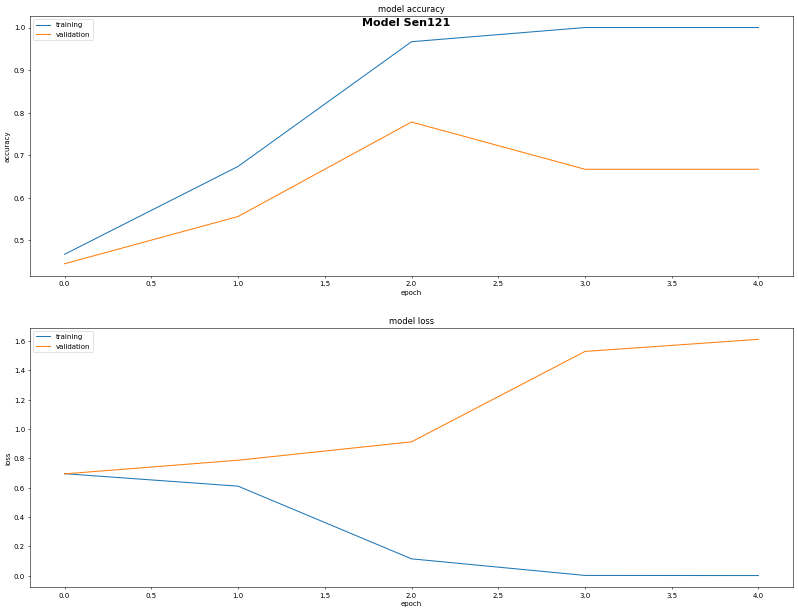

In [146]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 0s 73ms/step


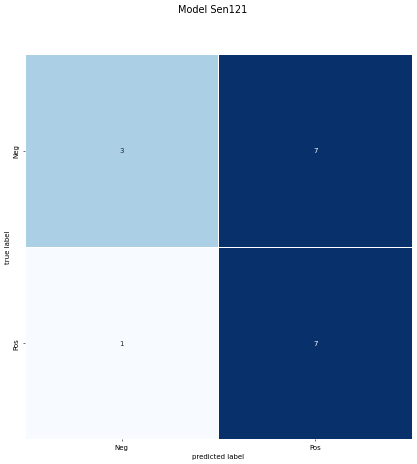

In [147]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Sen_122

In [148]:
%%time
run = False

model_code = '122'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  sen122=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen122

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 5.96 µs


In [149]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [150]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 72ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen122')

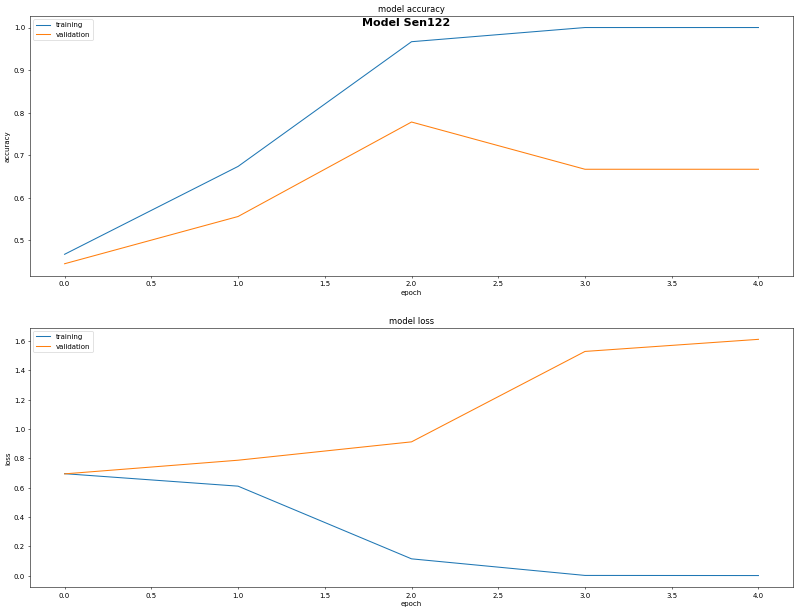

In [151]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 0s 72ms/step


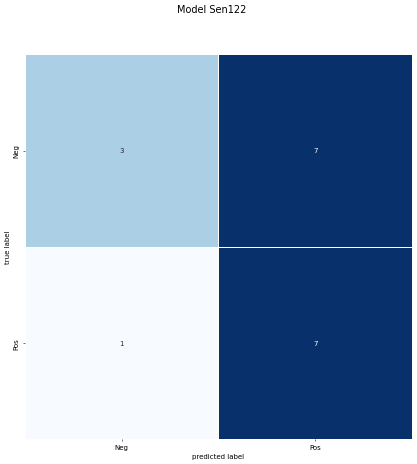

In [152]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Sen_211

In [153]:
%%time
run = False

model_code = '211'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.3

  sen211=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen211

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 6.68 µs


In [154]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [155]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 73ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen211')

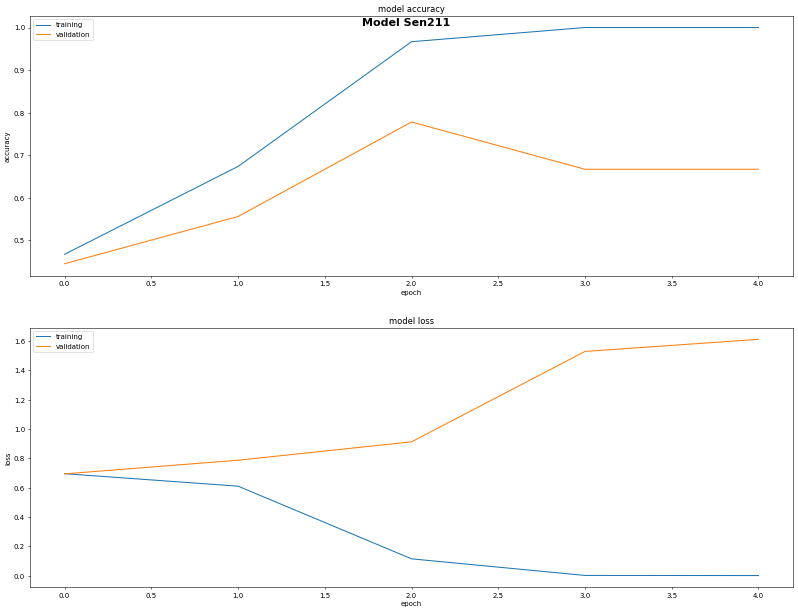

In [156]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 0s 71ms/step


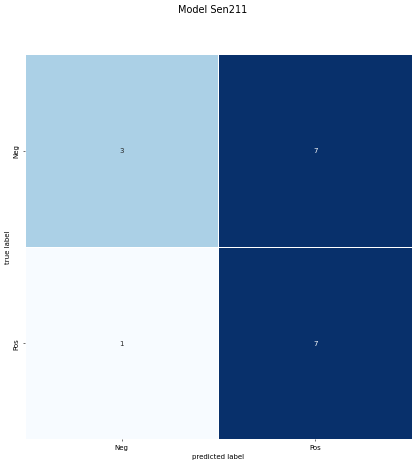

In [157]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Sen_212

In [158]:
%%time
run = False

model_code = '212'

if run == True:
  k.clear_session()
  encoder = encoder_5000
  dropout = 0.5

  sen212=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen212

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 8.11 µs


In [159]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [160]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 71ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen212')

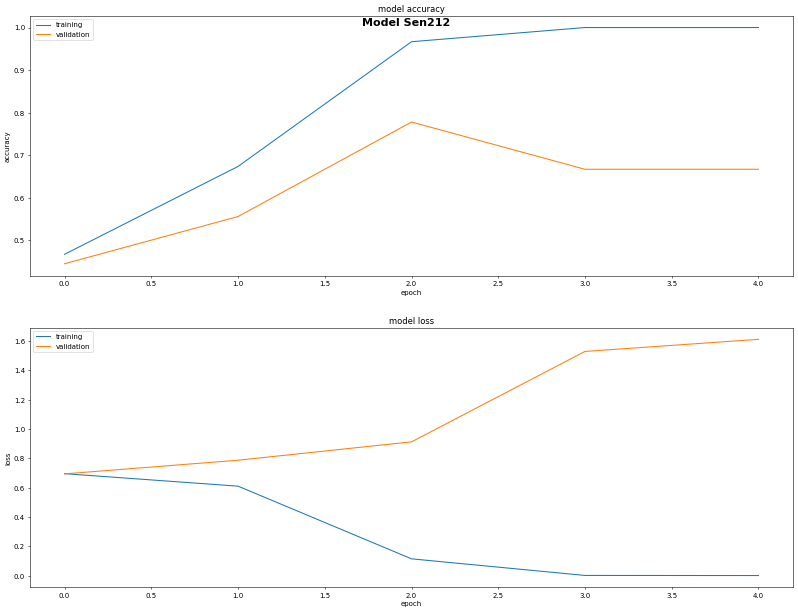

In [161]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 0s 71ms/step


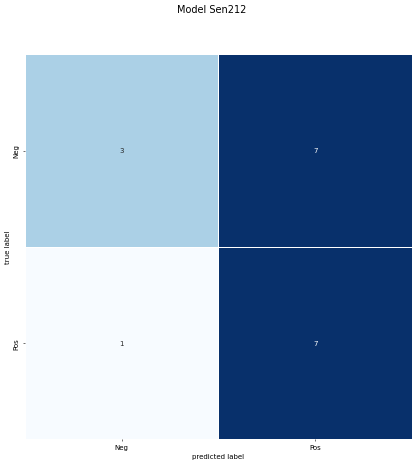

In [162]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)

### 3.2.1 Sen_221

In [163]:
%%time
run = False

model_code = '221'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.3

  sen221=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen221

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

CPU times: user 13 µs, sys: 1e+03 ns, total: 14 µs
Wall time: 7.39 µs


In [164]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

Test Performance

In [165]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 0s 74ms/step - loss: 2.0203 - accuracy: 0.5556
Test Loss: 2.0202581882476807
Test Accuracy: 0.5555555820465088


Text(0.5, 0.98, 'Model Sen221')

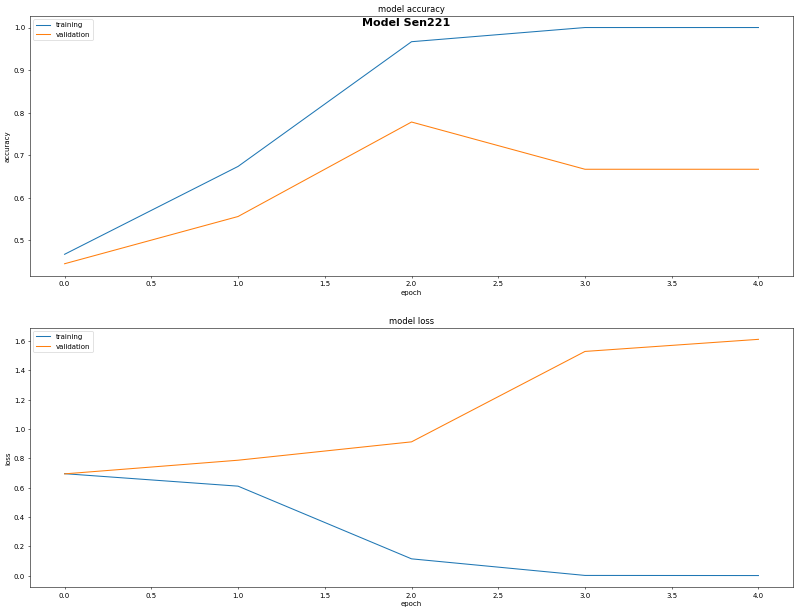

In [166]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 0s 80ms/step


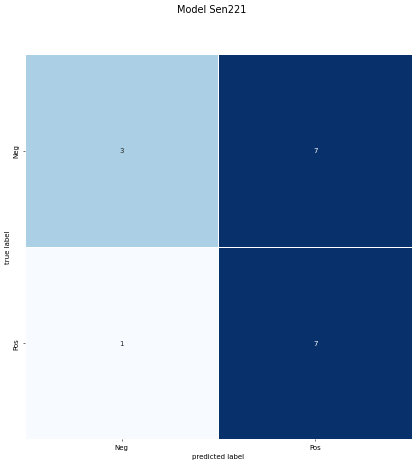

In [167]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)


### 3.2.2 Sen_222

In [168]:
%%time
run = True

model_code = '222'

if run == True:
  k.clear_session()
  encoder = encoder_7000
  dropout = 0.5

  sen222=tf.keras.Sequential([encoder
    ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 128, mask_zero=True)
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, dropout=dropout))
    ,tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,dropout=dropout))
    ,tf.keras.layers.Dense(64, activation='relu')
    ,tf.keras.layers.Dense(num_classes,activation='softmax')  
  ])

  model = sen222

  model.compile(optimizer= tf.keras.optimizers.Adam( )
                ,loss=tf.keras.losses.SparseCategoricalCrossentropy() 
                ,metrics=['accuracy'])

  history = model.fit(train_ds
          ,epochs=200
          ,validation_data=val_ds
          ,validation_steps=3
          ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/200
50/50 [==============================] - 60s 807ms/step - loss: 0.6980 - accuracy: 0.4600 - val_loss: 0.7126 - val_accuracy: 0.2222
Epoch 2/200
50/50 [==============================] - 34s 685ms/step - loss: 0.6329 - accuracy: 0.6867 - val_loss: 0.7444 - val_accuracy: 0.5556
Epoch 3/200
50/50 [==============================] - 34s 680ms/step - loss: 0.3202 - accuracy: 0.8667 - val_loss: 1.4085 - val_accuracy: 0.5556
Epoch 4/200
50/50 [==============================] - 34s 682ms/step - loss: 0.0610 - accuracy: 0.9867 - val_loss: 1.8143 - val_accuracy: 0.4444
CPU times: user 8min 4s, sys: 13.6 s, total: 8min 17s
Wall time: 3min 29s


In [169]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, None, 128)         896000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        164352    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                   

Test Performance

In [170]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

6/6 [==============================] - 1s 137ms/step - loss: 0.9722 - accuracy: 0.6667
Test Loss: 0.9722375869750977
Test Accuracy: 0.6666666865348816


Text(0.5, 0.98, 'Model Sen222')

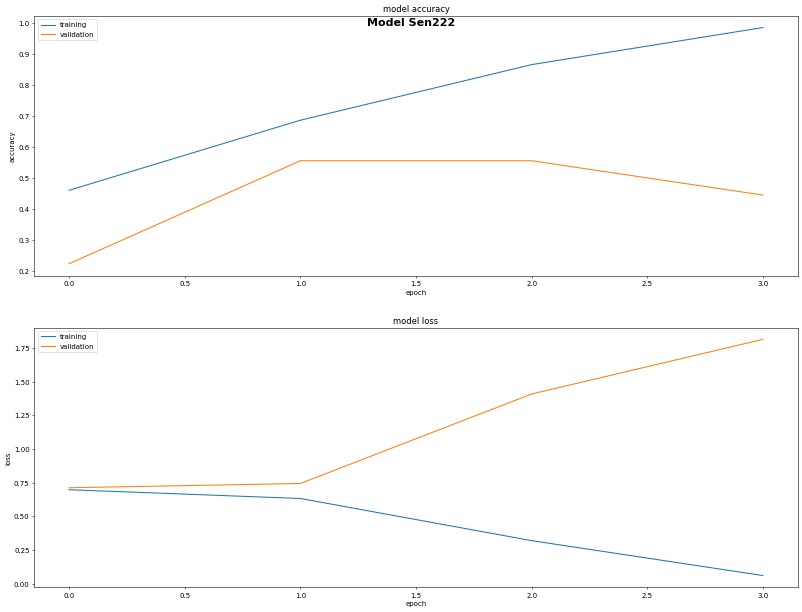

In [171]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

plt.suptitle(model_cat + model_code, fontsize=16, fontweight='bold')

6/6 [==============================] - 7s 114ms/step


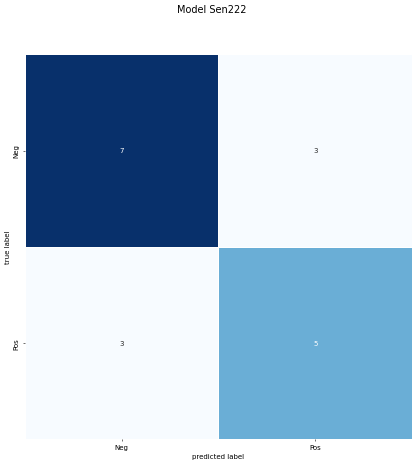

In [172]:
preds2 = model.predict(test_ds)
y_pred2 = np.argmax(preds2, axis=1)
y2 = np.concatenate([y for x, y in test_ds], axis=0)
plot_confusion_matrix_labeled(y2,y_pred2, CLASSES_LIST=CLASSES_LIST, model_code = model_cat + model_code)